### Cumulative Sum Test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

START_DATE = '2000-01-01'
END_DATE = pd.to_datetime('today')
TICKER = '^GSPC'

data = yf.download(
    TICKER,
    start = START_DATE,
    end = END_DATE,
    interval = '1d',
    progress = False
)

In [3]:
ret = data['Close'].pct_change().dropna()

2장에서 CUSUM filter를 소개했다. 그때는 바의 이벤트 기반 추출의 맥락에서 적용했다. 아이디어는 어떤 변수, 예컨데 누적 예측 오차가 사전에 정한 임계값을 초과할 경우 바를 추출하는 것이었다. 이런 개념은 구조적 변화를 테스트하는 것으로 확장할 수 있다.

#### 1. Brown-Durbin-Evans CUSUM Test on Recursive Residuals

이 테스트는 Brown-Durbin-Evans(1975)가 제안했다. 모든 관측값 $t = 1,\dots, T$에서 값 $y_t$를 예측하는 특성 $x_t$의 배열을 사용한다. 행렬 $X_t$는 특성의 $t \leq T, \{x_i\}_{i, \dots, t}$에서의 시계열로 구성된다. Brown-Durbin-Evans는 $\beta$의 재귀적 최소 자승법 추정치를 다음과 같은 설정에서 계산했다.

$$y_t = \beta_t^\prime x_t + \epsilon_t$$

이는 하위 샘플 $([1, k+1], [1, k+2], \dots, [1, T])$에 대한 적합화를 통해 $T-k$개의 최소 자승 추정치 $\left(\hat{\beta}_{k+1},\dots, \hat{\beta}_{T}\right)$를 생성한다. 여기서 표준화된 one step ahead 재귀적 잔차는 다음과 같이 계산할 수 있다.

$$\hat{\omega}_t = \frac{y_t - \hat{\beta}_{t - 1}x_t}{\sqrt{f_t}}$$
$$f_t = \hat{\sigma}_{\epsilon}^2 \left[ 1 + x_t^{\prime} (X_t ^{\prime} X_t)^{-1} x_t\right] $$

CUSUM 통계치는 다음과 같이 정의할 수 있다.

$$S_t = \sum_{j = k+1}^t \frac{\hat{\omega}_j}{\hat{\sigma}_{\omega}}$$
$$\hat{\sigma}_{\omega}^2 = \frac{1}{T-k} \sum_{t=k}^T (\hat{\omega}_t - E[\hat{\omega}_t])^2$$

$\beta$가 특정 상수값이라는 귀무가설, 즉 $H_0 : \beta_t = \beta$하에 $S_t \sim N[0, t - k - 1]$이다. 이 절차의 한 가지 단점을 시작점이 임의로 선정되므로 결과가 일치하지 않을 수 있다는 것이다.

In [108]:
class OneSideBrownDurbinEvans :
    def __init__(self, delta, h = None):
        self.delta = delta
        self.h = h
        self.G_list = None
        self.S_list = None
        self.G_min_idx = None
        self.cpd_idx = None
        
    def mean(self, x, k):
        if k == 0 : return x[k]
        return np.mean(x[:k])

    def var(self, x, k):
        return np.var(x[:k])
    
    def get_s_unknown(self, x, k, mul, delta, sigma):
        temp = (delta / sigma) * (x.iloc[k] - mul - 0.5 * delta)
        return temp
    
    def get_change_point(self, signal):
        G_list = []
        S_list = []
        G = 0
        S = 0
        delta = self.delta
        for k in range(len(signal)) :
            if k == 0:
                sigma = 1
                mul = 0
            else :
                mul = self.mean(signal, k + 1)
                sigma = self.var(signal, k + 1)
            s = self.get_s_unknown(signal, k, mul, delta, sigma)
            G = np.max([G + s, 0])
            S = S + s
            G_list.append(G)
            S_list.append(S)
        
        self.G_list = G_list
        self.S_list = S_list
        if self.h is not None :
            self.G_min_idx = np.min(np.where(np.array(G_list) > self.h)[0])
            target_S_list = S_list[:self.G_min_idx]
            self.cpd_idx = target_S_list.index(min(target_S_list))
        return self

In [160]:
osc = OneSideBrownDurbinEvans(delta = ret.median(), h = None).get_change_point(ret)

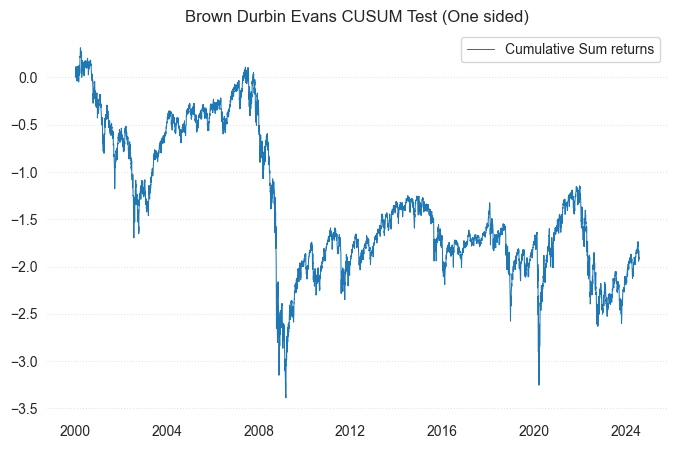

In [161]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    pd.Series(
        osc.S_list,
        index = ret.index
    ),
    label = 'Cumulative Sum returns',
    lw = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Brown Durbin Evans CUSUM Test (One sided)')
plt.show()

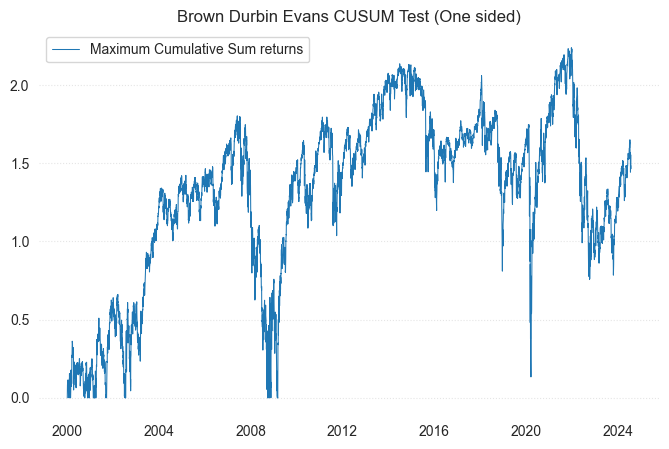

In [162]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    pd.Series(
        osc.G_list,
        index = ret.index
    ),
    label = 'Maximum Cumulative Sum returns',
    lw = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Brown Durbin Evans CUSUM Test (One sided)')
plt.show()

In [163]:
class TwoSidedBrownDurbinEvans :
    def __init__(self, delta, h=None):
        self.delta = delta
        self.h = h
        self.G_increase_list = None
        self.S_increase_list = None
        self.G_decrease_list = None
        self.S_decrease_list = None
        self.G_increase_min_idx = None
        self.increase_cpd_idx = None
        self.G_decrease_min_idx = None
        self.decrease_cpd_idx = None
 
    def mean(self, x, k):
        if k == 0:
            return x[k]
        return np.mean(x[:k])
    
    def var(self, x, k):
        return np.var(x[:k])
    
    def get_s_unknown(self, x, k, mu1, delta, sigma, sign):
        delta = abs(self.delta)
        if sign == 1:
            temp = (delta/sigma)*(x.iloc[k] - mu1 - 0.5*delta)
        else:
            temp = -(delta/sigma)*(x.iloc[k] - mu1 + 0.5*delta)
        return temp
    
    def get_change_point(self, signal):
        G_increase_list = []
        S_increase_list = []
        G_decrease_list = []
        S_decrease_list = []
 
        G_i = 0
        S_i = 0
        G_d = 0
        S_d = 0
        delta = abs(self.delta)
        for k in range(len(signal)):
            if k == 0:
                sigma = 1
                mu1 = 0
            else:
                mu1 = self.mean(signal, k+1)
                sigma = self.var(signal, k+1)
            s_i = self.get_s_unknown(signal, k, mu1, delta, sigma, 1)
            s_d = self.get_s_unknown(signal, k, mu1, delta, sigma, -1)
            G_i = np.max([G_i+s_i, 0])
            G_d = np.max([G_d+s_d, 0])
            S_i += s_i
            S_d += s_d
            G_increase_list.append(G_i)
            S_increase_list.append(S_i)
            G_decrease_list.append(G_d)
            S_decrease_list.append(S_d)
            
        self.G_increase_list = G_increase_list
        self.S_increase_list = S_increase_list
        self.G_decrease_list = G_decrease_list
        self.S_decrease_list = S_decrease_list
        if self.h is not None:
            self.G_increase_min_idx = np.min(np.where(np.array(G_increase_list) > self.h)[0])
            target_S_increase_list = S_increase_list[:self.G_increase_min_idx]
            self.increase_cpd_idx = target_S_increase_list.index(min(target_S_increase_list))
 
            self.G_decrease_min_idx = np.min(np.where(np.array(G_decrease_list) > self.h)[0])
            target_S_decrease_list = S_decrease_list[:self.G_decrease_min_idx]
            self.decrease_cpd_idx = target_S_decrease_list.index(min(target_S_decrease_list))
        return self

In [164]:
tsc = TwoSidedBrownDurbinEvans(delta = ret.median(), h = None).get_change_point(ret)

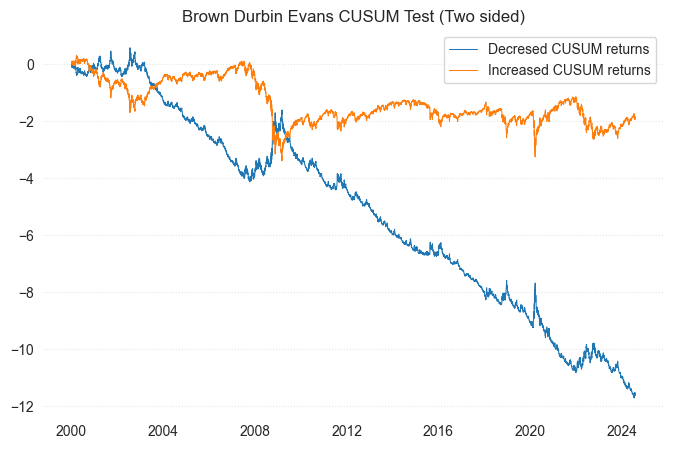

In [165]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    pd.Series(
        tsc.S_decrease_list,
        index = ret.index
    ),
    label = 'Decresed CUSUM returns',
    lw = 0.75
)
ax.plot(
    pd.Series(
        tsc.S_increase_list,
        index = ret.index
    ),
    label = 'Increased CUSUM returns',
    lw = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Brown Durbin Evans CUSUM Test (Two sided)')
plt.show()

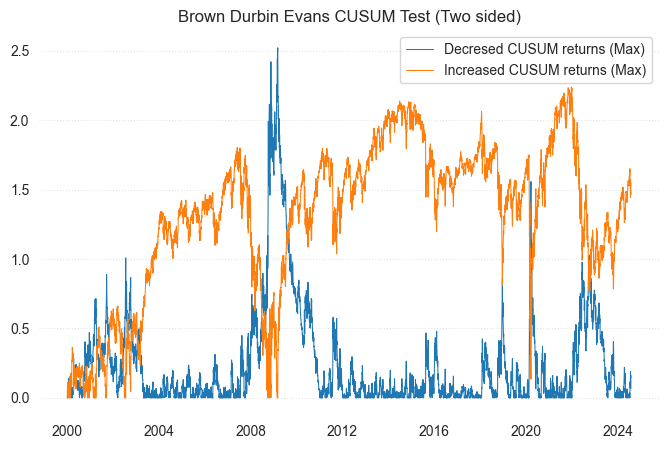

In [166]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    pd.Series(
        tsc.G_decrease_list,
        index = ret.index
    ),
    label = 'Decresed CUSUM returns (Max)',
    lw = 0.75
)
ax.plot(
    pd.Series(
        tsc.G_increase_list,
        index = ret.index
    ),
    label = 'Increased CUSUM returns (Max)',
    lw = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Brown Durbin Evans CUSUM Test (Two sided)')
plt.show()

#### 2. Chu-Stinchcombe-White CUSUM Test on Levels

이 검정은 Homm & Breitung(2012)의 논문에 따른다. 이전 기법에서 $\{x_t\}_{t = 1,\dots, T}$를 제거하고 $H_0 : \beta_t =0$을 가정해, 즉 변화가 없다는 것을 예측하는 것으로 단순화한다. 이 방법은 $y_t$수준으로 직접적으로 작업할 수 있어 계산 부담을 덜 수 있다. 여기서는 로그 가격$y_n (t > n)$와 비교하여 로그 가격 $y_t$의 표준화된 이격을 다음과 같이 계산한다.

$$S_{n,t} = \left( y_t - y_n \right) \left( \hat{\sigma}_t \sqrt{t - n}\right)^{-1}$$
$$\hat{\sigma}_t^2 = (t - 1)^{-1} \sum_{i=2}^t \left(\Delta y_i\right)^2$$

귀무가설 $H_0 : \beta_t = 0$하에 $S_{n,t} \sim N(0, 1)$이다. 단측 검정의 시간 의존 임계값은 다음과 같다. 

$$c_{\alpha}(n, t) = \sqrt{b_{\alpha} + \log(t - n)}$$

Homm & Breitung은 Montecarlo Simulation을 통해 $b_{\alpha = 0.05} = 4.6$이라는 것을 도출했다. 이 기법의 한 가지 단점은 참고 수준 $y_n$이 다소 임의로 설정된다는 것이다. 이 문제를 해결하고자 $S_{n,t}$를 backward-shifting하는 윈도우 $n \in (1, t)$의 계열에 대해 추정하고 $S_t = \sum_{n \in (1, t)} \left\{ S_{n,t}\right\}$를 선택할 수도 있다.

In [172]:
from FinancialMachineLearning.regime_change.cusum_test import get_chu_stinchcombe_white_statistics

csw_one_side = get_chu_stinchcombe_white_statistics(
    series = np.log(data['Close']),
    test_type = 'one_sided',
    num_threads = 8
)

2024-08-02 00:37:15.944902 100.0% get_s_n_for_t done after 2.16 minutes. Remaining 0.0 minutes.


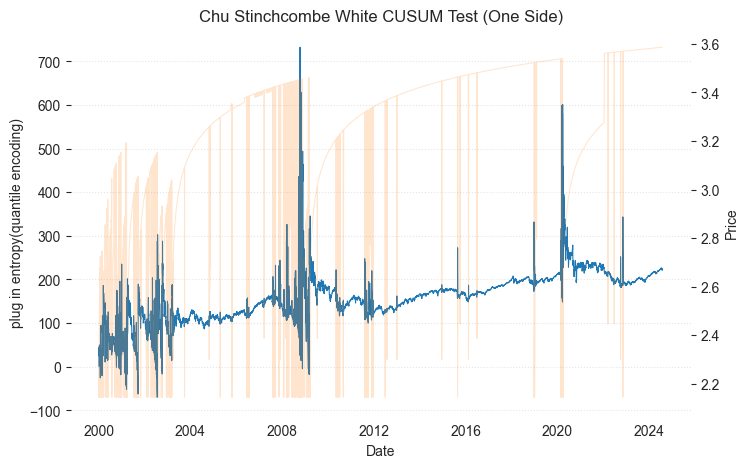

In [176]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(
    csw_one_side['stat'],
    lw = 0.75
)
ax1.set_xlabel('Date') 
ax1.set_ylabel('plug in entropy(quantile encoding)') 
ax1.grid(False)
ax1.yaxis.grid(True, ls=':', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_visible(False)

ax2 = ax1.twinx() 
ax2.plot(
    csw_one_side['critical_value'],
    color = 'tab:orange',
    lw = 0.75,
    alpha = 0.2
)
ax2.grid(False)
ax2.set_ylabel('Price') 
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.xticks(rotation = 45)
plt.title('Chu Stinchcombe White CUSUM Test (One Side)')
plt.show()

In [175]:
csw_two_side = get_chu_stinchcombe_white_statistics(
    series = np.log(data['Close']),
    test_type = 'two_sided',
    num_threads = 8
)

024-08-02 00:40:32.645300 50.0% get_s_n_for_t done after 1.19 minutes. Remaining 1.19 minutes.2024-08-02 00:41:02.634833 75.0% get_s_n_for_t done after 1.69 minutes. Remaining 0.56 minutes.2024-08-02 00:41:28.570194 100.0% get_s_n_for_t done after 2.12 minutes. Remaining 0.0 minutes.


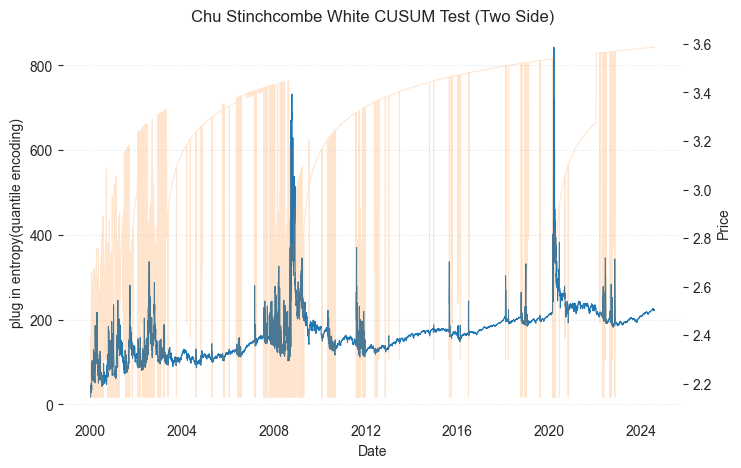

In [177]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(
    csw_two_side['stat'],
    lw = 0.75
)
ax1.set_xlabel('Date') 
ax1.set_ylabel('plug in entropy(quantile encoding)') 
ax1.grid(False)
ax1.yaxis.grid(True, ls=':', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_visible(False)

ax2 = ax1.twinx() 
ax2.plot(
    csw_two_side['critical_value'],
    color = 'tab:orange',
    lw = 0.75,
    alpha = 0.2
)
ax2.grid(False)
ax2.set_ylabel('Price') 
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.xticks(rotation = 45)
plt.title('Chu Stinchcombe White CUSUM Test (Two Side)')
plt.show()
